# Western Tanager Migration throughout 2024

### Step 1: Install the pygbif package in your environment

If you're on a PC, open Git Bash in the Terminal at the bottom of the Jupyter notebook, and enter this: 

`pip install pygbif`

If you're on a Mac, paste the following code block into a Python cell and run it:

```python
%%bash
pip install pygbif
```

### Step 2: Import Libraries

In [26]:
# Import Libraries

import calendar
import hvplot.pandas 
import pathlib
import os
import time
import zipfile

from getpass import getpass
from glob import glob

import cartopy.crs as ccrs
import geopandas as gpd
import pandas as pd
import panel as pn 
import pygbif.occurrences as occ
import pygbif.species as species

### Step 3: Create a data directory

In [2]:
# create data directory
wtan_data_dir = os.path.join(

    # Home Directory
    pathlib.Path.home(),

    # Earth Analytics Data Directory
    'Documents',
    'Graduate_School',
    'EDA_Certificate',
    'data',
    # Project Directory
    'migration-portfolio'
)

# make the directory
os.makedirs(wtan_data_dir, exist_ok = True)

# define directory for gbif data
gbif_dir = os.path.join(wtan_data_dir, 'gbif_downloads')

# make the directory
os.makedirs(gbif_dir, exist_ok = True)

gbif_dir

'C:\\Users\\raini\\Documents\\Graduate_School\\EDA_Certificate\\data\\migration-portfolio\\gbif_downloads'

### Step 4: Download the Ecoregions File

say something about where this is from, etc

In [3]:
# Download Ecoregions file

# Set ecoregion directory
eco_dir = os.path.join(wtan_data_dir, 'resolve_ecoregions')

# Make ecoregion directory
os.makedirs(eco_dir, exist_ok=True)

# Path to ecoregion file
eco_path = os.path.join(eco_dir, 'ecoregions.shp')

# Set download url
eco_url = (
    'https://storage.googleapis.com/teow2016/'
    'Ecoregions2017.zip'
)

# Check to see if the file has already been downloaded
# If it hasn't, this will download and save the shapefile
if not os.path.exists(eco_path):
    gdf = gpd.read_file(eco_url)
    gdf.to_file(eco_path)

In [4]:
# Check that the file exists using Python

if os.path.exists(eco_path)==True:
    print('The download worked!')
else:
    print('The download failed.')

The download worked!


Now load the ecoregions into Python:

In [5]:
# Open up the downloaded shapefile
eco_gdf = (
    gpd.read_file(eco_path)
    # only read in the columns we need
    [['OBJECTID', 'ECO_NAME', 'SHAPE_AREA', 'geometry']]
    # rename columns
    .rename(columns = {
        'OBJECTID': 'ecoregion_id',
        'ECO_NAME': 'name',
        'SHAPE_AREA': 'area'
    })
    # set index
    .set_index('ecoregion_id')
)

# Check out the file to make sure things are looking ok
eco_gdf.head()

name       area  \
ecoregion_id                                                                 
1.0                                          Adelie Land tundra   0.038948   
2.0                      Admiralty Islands lowland rain forests   0.170599   
3.0           Aegean and Western Turkey sclerophyllous and m...  13.844952   
4.0                                Afghan Mountains semi-desert   1.355536   
5.0                            Ahklun and Kilbuck Upland Tundra   8.196573   

                                                       geometry  
ecoregion_id                                                     
1.0           MULTIPOLYGON (((158.7141 -69.60657, 158.71264 ...  
2.0           MULTIPOLYGON (((147.28819 -2.57589, 147.2715 -...  
3.0           MULTIPOLYGON (((26.88659 35.32161, 26.88297 35...  
4.0           MULTIPOLYGON (((65.48655 34.71401, 65.52872 34...  
5.0           MULTIPOLYGON (((-160.26404 58.64097, -160.2673...

<Axes: >

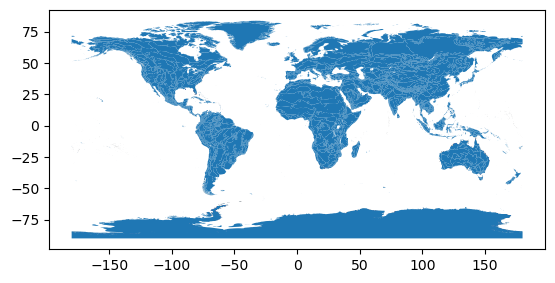

In [6]:

# Plot the ecoregions quickly to check that everything is working
eco_gdf.plot()

### Step 5: Download the GBIF Observation Data

For this project, I've chosen the Western Tanager (Piranga ludoviciana) as the species I'd like to work with. I've created an account on the GBIF website [(gbif.org)](<https://www.gbif.org/)>), and use my credentials here to download the data.

##### First, link GBIF to the Python notebook
- Change to `reset = True` the first time you run it. When you run it, you'll be prompted to enter your GBIF username, password, and associated email address
- Then change it back to `reset = False` so you can re-run the chunk without having to reconnect to GBIF
- You don’t need to modify this code chunk in any other way

In [7]:
####--------------------------####
#### DO NOT MODIFY THIS CODE! ####
####--------------------------####
# This code ASKS for your credentials 
# and saves it for the rest of the session.
# NEVER put your credentials into your code!!!!

# GBIF needs a username, password, and email 
# All 3 need to match the account
reset = False

# Request and store username
if (not ('GBIF_USER'  in os.environ)) or reset:
    os.environ['GBIF_USER'] = input('GBIF username:')

# Securely request and store password
if (not ('GBIF_PWD'  in os.environ)) or reset:
    os.environ['GBIF_PWD'] = getpass('GBIF password:')
    
# Request and store account email address
if (not ('GBIF_EMAIL'  in os.environ)) or reset:
    os.environ['GBIF_EMAIL'] = input('GBIF email:')

##### Second, get the species key for the Western Tanager from GBIF using the `name_backbone` command

In [8]:
# grab the species info
backbone = species.name_backbone(name = 'Piranga ludoviciana')

# check it out
backbone

{'usageKey': 2488484,
 'scientificName': 'Piranga ludoviciana (A.Wilson, 1811)',
 'canonicalName': 'Piranga ludoviciana',
 'rank': 'SPECIES',
 'status': 'ACCEPTED',
 'confidence': 99,
 'matchType': 'EXACT',
 'kingdom': 'Animalia',
 'phylum': 'Chordata',
 'order': 'Passeriformes',
 'family': 'Cardinalidae',
 'genus': 'Piranga',
 'species': 'Piranga ludoviciana',
 'kingdomKey': 1,
 'phylumKey': 44,
 'classKey': 212,
 'orderKey': 729,
 'familyKey': 9285,
 'genusKey': 2488483,
 'speciesKey': 2488484,
 'class': 'Aves'}

In [9]:
# pull out the species key
species_key = backbone['usageKey']

# check it out
species_key

2488484

##### Third, download the GBIF Observation Data via the API

In [10]:
# Only download once
gbif_pattern = os.path.join(gbif_dir, '*.csv')

if not glob(gbif_pattern):
    # Only submit one request
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        # Submit query to GBIF
        gbif_query = occ.download([
            f'speciesKey = {species_key}',
            'hasCoordinate = True',
            'year = 2024',
        ])
        # Take first result
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]

    # Wait for the download to build
    dld_key = os.environ['GBIF_DOWNLOAD_KEY']
    wait = occ.download_meta(dld_key)['status']
    while not wait=='SUCCEEDED':
        # This makes it so our code doesn't query the GBIF server too frequently
        wait = occ.download_meta(dld_key)['status']
        time.sleep(5)

    # Download GBIF data
    dld_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'], 
        path = gbif_dir)
    dld_path = dld_info['path']

    # Unzip GBIF data
    with zipfile.ZipFile(dld_path) as dld_zip:
        dld_zip.extractall(path=gbif_dir)
        
    # Clean up the .zip file
    os.remove(dld_path)
    
# Find the extracted .csv file path (first result)
original_gbif_path = glob(gbif_pattern)[0]
original_gbif_path

'C:\\Users\\raini\\Documents\\Graduate_School\\EDA_Certificate\\data\\migration-portfolio\\gbif_downloads\\0049809-251009101135966.csv'

### Step 6: Load GBIF Observation Data into Python

In [11]:
!head -n 2 $original_gbif_path

gbifID	datasetKey	occurrenceID	kingdom	phylum	class	order	family	genus	species	infraspecificEpithet	taxonRank	scientificName	verbatimScientificName	verbatimScientificNameAuthorship	countryCode	locality	stateProvince	occurrenceStatus	individualCount	publishingOrgKey	decimalLatitude	decimalLongitude	coordinateUncertaintyInMeters	coordinatePrecision	elevation	elevationAccuracy	depth	depthAccuracy	eventDate	day	month	year	taxonKey	speciesKey	basisOfRecord	institutionCode	collectionCode	catalogNumber	recordNumber	identifiedBy	dateIdentified	license	rightsHolder	recordedBy	typeStatus	establishmentMeans	lastInterpreted	mediaType	issue
5835936327	e635240a-3cb1-4d26-ab87-57d8c7afdfdb	b7ed2b96-3213-4ffe-87ed-88174e6612aa	Animalia	Chordata	Aves	Passeriformes	Cardinalidae	Piranga	Piranga ludoviciana		SPECIES	Piranga ludoviciana (A.Wilson, 1811)	Piranga ludoviciana		US	Gilbert-Baker Wildlife Management Area	Nebraska	PRESENT		b554c320-0560-11d8-b851-b8a03c50a862	42.770317	-103.939122	3.0						2024-0

In [12]:
gbif_df = pd.read_csv(
    original_gbif_path,

    # The dataset is tab delimited, so we set the delimiter to \t (tab)
    delimiter='\t',
    # We'll use the gbifID as the index, as there's a unique value in every row
    index_col= 'gbifID',
    # We only need these columns to do the plotting.
    # Feel free to comment out the row to see the whole dataset
    usecols= ['gbifID', 'month', 'decimalLatitude', 'decimalLongitude']
)

gbif_df.head()

decimalLatitude  decimalLongitude  month
gbifID                                              
5835936327        42.770317       -103.939122      6
5835936343        42.765938       -103.944211      6
5835936316        42.765938       -103.944211      6
5196101425        40.043866       -105.282882      7
5196101437        40.268283       -105.353865      9

In [13]:
# Save the DF as a .csv for future use

wtan_path = os.path.join(gbif_dir, 'western_tanager_gbif.csv')
gbif_df.to_csv(wtan_path)

### Step 7: Convert the GBIF DF to a GeoDataFrame

In [14]:
# this step converts the dataFrame to a GeoDataFrame, which we'll need for plotting
### It converts the Latitude and Longitude columns to a single point geometry

gbif_gdf = (
    gpd.GeoDataFrame(
        gbif_df, 
        geometry=gpd.points_from_xy(
            gbif_df.decimalLongitude, 
            gbif_df.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['month', 'geometry']]
)

gbif_gdf.head()

month                     geometry
gbifID                                        
5835936327      6  POINT (-103.93912 42.77032)
5835936343      6  POINT (-103.94421 42.76594)
5835936316      6  POINT (-103.94421 42.76594)
5196101425      7  POINT (-105.28288 40.04387)
5196101437      9  POINT (-105.35386 40.26828)

### Step 8: Join the Ecoregions and the GBIF Observations

In [ ]:
gbif_eco_gdf = (
    eco_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_gdf.crs)

    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how='inner', 
        # an inner join removes ecoregions that have no Western Tanager sightings, 
        # and any Western Tanager sighting that aren't in any ecoregions.
        predicate='contains')
)

gbif_eco_gdf

name       area  \
ecoregion_id                                                          
13.0          Alberta-British Columbia foothills forests  17.133639   
13.0          Alberta-British Columbia foothills forests  17.133639   
13.0          Alberta-British Columbia foothills forests  17.133639   
13.0          Alberta-British Columbia foothills forests  17.133639   
13.0          Alberta-British Columbia foothills forests  17.133639   
...                                                  ...        ...   
839.0                   Northern Rockies conifer forests  35.905513   
839.0                   Northern Rockies conifer forests  35.905513   
839.0                   Northern Rockies conifer forests  35.905513   
839.0                   Northern Rockies conifer forests  35.905513   
839.0                   Northern Rockies conifer forests  35.905513   

                                                       geometry      gbifID  \
ecoregion_id                                                                  
13.0          MULTIPOLYGON (((-119.53979 55.81661, -119.5443...  5345811763   
13.0          MULTIPOLYGON (((-119.53979 55.81661, -119.5443...  5301391573   
13.0          MULTIPOLYGON (((-119.53979 55.81661, -119.5443...  5431175796   
13.0          MULTIPOLYGON (((-119.53979 55.81661, -119.5443...  5635464413   
13.0          MULTIPOLYGON (((-119.53979 55.81661, -119.5443...  5489232257   
...                                                         ...         ...   
839.0         POLYGON ((-119.99977 54.53117, -119.8914 54.45...  5576190307   
839.0         POLYGON ((-119.99977 54.53117, -119.8914 54.45...  5308319435   
839.0         POLYGON ((-119.99977 54.53117, -119.8914 54.45...  5063921959   
839.0         POLYGON ((-119.99977 54.53117, -119.8914 54.45...  5550911758   
839.0         POLYGON ((-119.99977 54.53117, -119.8914 54.45...  5382641305   

              month  
ecoregion_id         
13.0              6  
13.0              5  
13.0              6  
13.0              6  
13.0              6  
...             ...  
839.0             8  
839.0             7  
839.0             8  
839.0             6  
839.0             5  

[182257 rows x 5 columns]

### Step 9: Group observations and normalize them

Now, we're going to manipulate the dataset in a few ways to get it ready to plot in a meaningful way:
- We're going to count the GBIF observations in each ecoregion and in each month. 
- We'll also remove rare occurences, as those are more likely to be erroneous identifications than actual observations. 
- We'll normalize the data to the area of the ecoregion
- We'll count the average occurences by month and by ecoregion

Once we've completed these steps, we can normalize the occurences to account for temporal and spatial biases.
- Temporal biases are reductions in observations that are caused by fewer people taking observations at a certain time of year, rather than by fewer individuals in given area. For example, in the winter, fewer people might go birding, because it's cold and snowy outside; or, if there's a heatwave in the summer, more people might stay inside where there's air conditioning.
- Spatial biases would artificially increase or decrease observations due to the density of people taking observations relative to the size of a given ecoregion. For example, there might be more observations along the Front Range of Colorado vs deep in the Amazon rainforest, because the density of observers is much higher.

In [20]:
occurrence_df = (
    gbif_eco_gdf
    # For each ecoregion, for each month...
    .groupby(['ecoregion_id', 'month'])
    # ...count the number of occurrences
    .agg(
        occurrences=('gbifID', 'count'),
        area=('area', 'first')
        )
)

# Get rid of rare observations (possible misidentification?)
occurrence_df = occurrence_df[occurrence_df.occurrences > 1]

# Normalize by area
occurrence_df['density'] = (
    occurrence_df.occurrences
    / occurrence_df.area
)

occurrence_df

occurrences       area    density
ecoregion_id month                                   
13.0         5               36  17.133639   2.101130
             6               86  17.133639   5.019366
             7               17  17.133639   0.992200
             8                6  17.133639   0.350188
35.0         1              153  16.433620   9.310182
...                         ...        ...        ...
839.0        5             1462  35.905513  40.717981
             6             2520  35.905513  70.184207
             7             1297  35.905513  36.122586
             8              630  35.905513  17.546052
             9              122  35.905513   3.397807

[669 rows x 3 columns]

In [21]:
# Take the mean by month
mean_occurrences_by_month = (
    occurrence_df
    .groupby('month')
    .mean()
)

mean_occurrences_by_month

occurrences        area     density
month                                     
1        87.215686    7.740375   35.454885
2        71.115385    7.840923   34.942127
3        76.666667    7.112853   34.657288
4       136.347222   11.378444   30.780439
5       746.133333   15.586510  123.004459
6       701.943396  144.818625  107.352565
7       469.282609   20.243034   70.338037
8       361.944444   15.938654   53.756315
9       315.385965   14.474600   57.442205
10       55.600000    9.768700   16.231264
11       43.869565    7.884057   19.122725
12       52.618182    8.467423   26.770174

In [22]:

# Take the mean by ecoregion
mean_occurrences_by_ecoregion = (
    occurrence_df
    .groupby('ecoregion_id')
    .mean()
)

mean_occurrences_by_ecoregion

occurrences       area     density
ecoregion_id                                    
13.0            36.250000  17.133639    2.115721
35.0            36.000000  16.433620    2.190631
44.0           796.142857  10.853227   73.355407
50.0            50.800000   1.514407   33.544478
57.0             3.333333   1.928691    1.728288
...                   ...        ...         ...
821.0            2.000000  26.034401    0.076821
827.0            7.250000   9.664680    0.750154
828.0            3.000000  64.674744    0.046386
838.0          653.800000   4.286144  152.538039
839.0         1006.666667  35.905513   28.036548

[112 rows x 3 columns]

In [23]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences'] = (
    occurrence_df['density']
    # Divide by ecoregion and month. This is minimizing effects of seasonality 
    # (cold, no one going out) or population (no one taking obs) biases
    / mean_occurrences_by_ecoregion['density']
    / mean_occurrences_by_month['density']
)

occurrence_df

occurrences       area    density  norm_occurrences
ecoregion_id month                                                     
13.0         5               36  17.133639   2.101130          0.008074
             6               86  17.133639   5.019366          0.022099
             7               17  17.133639   0.992200          0.006667
             8                6  17.133639   0.350188          0.003079
35.0         1              153  16.433620   9.310182          0.119871
...                         ...        ...        ...               ...
839.0        5             1462  35.905513  40.717981          0.011807
             6             2520  35.905513  70.184207          0.023319
             7             1297  35.905513  36.122586          0.018317
             8              630  35.905513  17.546052          0.011642
             9              122  35.905513   3.397807          0.002110

[669 rows x 4 columns]

We can make a quick plot to visualize this:

## REWATCH THE VIDEO AND EXPLAIN WHAT THE PLOT MEANS

<Axes: xlabel='month', ylabel='norm_occurrences'>

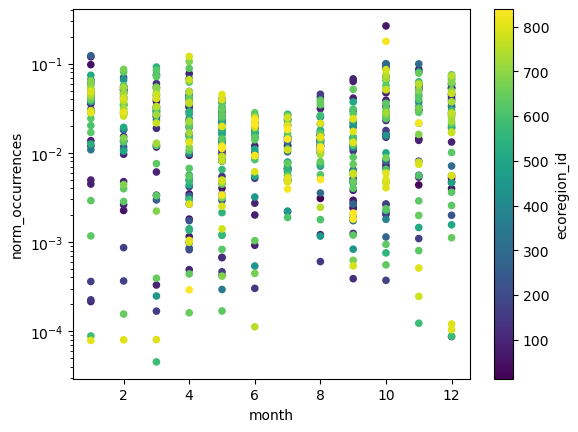

In [24]:
# Quick Plot to make sure things look good

occurrence_df.reset_index().plot.scatter(
    x = 'month', y = 'norm_occurrences', c = 'ecoregion_id',
    logy = True
)

# These plots give me a quick glance at the data. 
# Not sure I fully understand how to read them or make something 
# similar with different data, but we'll get there.

### Step 10: Get the data ready to make a dynamic plot

Plotting the observations as they exist now would be extremely time consuming and resource intensive. We'll want to simplify the geometries of the ecoregions so that the plotting function runs more easily - and luckily, this won't really impact the appearance of the plot. We'll also need to change the CRS to Mercator to work with the plotting function.

In [27]:
# Simplify the geometry to speed up processing
eco_gdf.geometry = eco_gdf.simplify(.1, preserve_topology=False)

# Change the CRS to Mercator for mapping (all tiles are Mercator)
eco_gdf = eco_gdf.to_crs(ccrs.Mercator())

# Check that the plot runs in a reasonable amount of time
eco_gdf.hvplot(geo=True, crs=ccrs.Mercator())

:Polygons   [Longitude,Latitude]

In [50]:
# Join the occurrences with the plotting GeoDataFrame
occurrence_gdf = eco_gdf.join(occurrence_df[['norm_occurrences']])

# Empty geometries will cause error codes, so we'll remove those
occurrence_gdf = occurrence_gdf[~occurrence_gdf.geometry.is_empty]

# Check to ensure that all rows of the gdf have information
print(f"The number of rows with empty geometry is {occurrence_gdf.geometry.is_empty.sum()}.")

# After testing the plot, it looks like there's one observation of Western Tanagers in the 'Rock and Ice' ecoregion. 
# This ecoregion includes major icefields, such as Antarctica, Greenland, and the Patagonian ice fields. 
# These regions are not places that Western Tanagers live, so we'll need to remove that ecoregion from the observations.

removal_condition = occurrence_gdf.name == 'Rock and Ice'
occurrence_gdf = occurrence_gdf[~removal_condition]

# Check that we've removed that ecoregion
if (occurrence_gdf['name'] != 'Rock and Ice').any():
    print('Rows with Rock and Ice have been removed.')
else:
    print('Removal needed')

The number of rows with empty geometry is 0.
Rows with Rock and Ice have been removed.


### Step 11: Make the dynamic plot!

In [52]:

# Get the plot bounds so they don't change with the slider
xmin, ymin, xmax, ymax = occurrence_gdf.to_crs(ccrs.Mercator()).total_bounds

# Set up the month widget to display names on the plot slider
month_widget = pn.widgets.DiscreteSlider(
    options={
        calendar.month_name[month_num]: month_num
        for month_num in range(1,13)
    }
)

# Plot occurrence by ecoregion and month
migration_plot = (
    occurrence_gdf
    .hvplot(
        c='norm_occurrences',
        groupby='month',
        # Use background tiles
        geo=True, crs=ccrs.Mercator(), tiles='CartoLight',
        title="Western Tanager Migration throughout 2024",
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        frame_height=600,
        widgets={'month': month_widget},
        widget_location='bottom'
    )
)

# Save the plot
migration_plot.save('western_tanager_migration.html', embed=True)

# Show the plot
migration_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'475b77e7-c876-4061-bb28-f09f42f22472': {'version…